# Homework 4: Analyzing Rates of Sea Level Rise
In this homework, you'll investigate sea level change using data from the ECCO state estimate. You'll look at spatial differences over the past few decades and then compare how sea level on the California coast compares to the global mean.

Begin by importing the modules you'll need for this notebook:

In [2]:
# import packages here
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import netCDF4 as nc4
import glob
import os

## Part 1: Download Sea Surface Height Data
To begin this exercise, download all of the available sea surface height data (1992-2017) from the ECCO Version 4 Release 4 output. There are several different variables for sea surface height pertaining to different components and corrections. In this homework, we'll use the `SSHDYN` variable which is equivalent to what satellites would measure from space.

To obtain the data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes.

In [4]:
# define the path to the folder where the SSH data has been download on your machine
data_folder = r'C:\\Users\\Hetav\\OneDrive\\Desktop\\CS185C\\homework_4'
ssh_folder = os.path.join(data_folder, 'Version4', 'Release4', 'interp_monthly', 'SSHDYN')

## Part 2: Plot Total Sea Level Rise 1992-2017
As a first look into how sea level has changed in the past several decades, we'll look at the differences between two time periods at the beginning and end of the available model output: January 1992 and January 2017. It is important to use the same month because variations in sea level also have a seasonal cycle (as we'll see below). Begin by reading in the data:

In [6]:
# read in the longitude, latitude, and model ssh grid in January 1992 (SSHDYN_1992_01.nc)
ds_ssh_1992 = xr.open_dataset(os.path.join(ssh_folder, 'SSHDYN_1992_01.nc'))
latitudes_1992 = ds_ssh_1992['latitude'].values
longitudes_1992 = ds_ssh_1992['longitude'].values
ssh_data_1992 = ds_ssh_1992['SSHDYN'].values
ds_ssh_1992.close()

# read in the model ssh grid in January 2017 (SSHDYN_2017_01.nc)
ds_ssh_2017 = xr.open_dataset(os.path.join(ssh_folder, 'SSHDYN_2017_01.nc'))
ssh_data_2017 = ds_ssh_2017['SSHDYN'].values
ds_ssh_2017.close()

Now, make a plot of the difference between January 2017 and January 1992. Be sure to add a colorbar with a divergent colormaps and set the color bounds to be equal in the positive and negative directions.

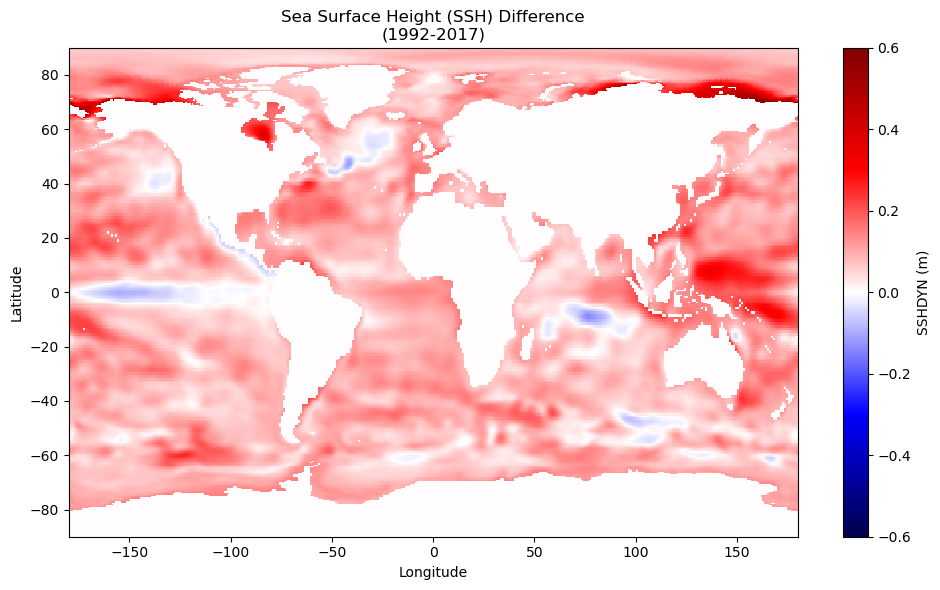

In [8]:
ssh_difference = ssh_data_2017 - ssh_data_1992

# Plot the differences between 2017 and 1992
fig = plt.figure(figsize=(10,6))
cmap = plt.pcolormesh(longitudes_1992, latitudes_1992, ssh_difference[0], cmap='seismic', vmin=-0.6, vmax=0.6)

plt.colorbar(cmap, orientation='vertical', label='SSHDYN (m)')
plt.title('Sea Surface Height (SSH) Difference\n(1992-2017)')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.tight_layout()
plt.show()

### Questions:
Where are the largest increases in sea level observed between these two time periods? Are there any locations on the globe where sea level has fallen? If so, where?

Answer: The largest sea level increase was 0.57 m.
Sea level fell in these regions (blue areas):
West of South America (equator)
South of Greenland, east of Canada
West of California and Mexico
East of Africa
South of Australia

## Part 3: Create a Timeseries of Sea Surface Height in California
Next, we'll make a timeseries of sea surface height at a point off the California coast near San José. A close location in the model is at 37$^{\circ}$N, 122$^{\circ}$W. Begin by finding the closest row and column in the model grid to this longitude and latitude.

In [11]:
# Define the target longitude and latitude for the point off the CA coast
target_lon = -122
target_lat = 37

# Find the row and column indices closest to the target location
lat_index = np.argmin(np.abs(latitudes_1992 - target_lat))
lon_index = np.argmin(np.abs(longitudes_1992 - target_lon))

# Get and sort all SSH files in the specified folder
ssh_file_paths = glob.glob(os.path.join(ssh_folder, 'SSHDYN_*.nc'))
ssh_file_paths.sort()
print(f'{len(ssh_file_paths)} files found')


312 files found


Now, armed with your sample location, loop through each sea surface height file to make a timeseries of sea level rise between 1992 and 2017. Every time you access a file, sample the model grid at the row and column you identified above.

In [13]:
# Create a time series of SSH at the target location by looping through all SSH files
# Each loop iteration samples the SSH grid at the row and column indices identified earlier
# The time series will be an (N, 2) array with time in the first column and SSH values in the second column

cal_ssh_time_series = np.zeros((len(ssh_file_paths), 2))

for idx, file_path in enumerate(ssh_file_paths):
    print(f'{idx + 1} of {len(ssh_file_paths)}', end='\r')
    dataset = xr.open_dataset(file_path)
    cal_ssh_time_series[idx, 0] = dataset['time'].values[0]  # Time in the first column
    cal_ssh_time_series[idx, 1] = dataset['SSHDYN'].values[0, lat_index, lon_index]  # SSH value at the target location
    dataset.close()

print(f'\nTime Series Shape: {cal_ssh_time_series.shape}')

312 of 312
Time Series Shape: (312, 2)


## Part 4: Create a Timeseries of Global Mean Sea Surface Height
Next, make a timeseries of sea surface height averaged across the globe. Your loop should look quite similar to that above - you'll just need to make a slight change to average across the whole ocean rather than sampling at a single point.

In [15]:
# create a timeseries of the global mean ssh by looping through all of the ssh files
# each time through the loop, take the mean of the ssh grid at the row and column identified above
# when you take the mean, be sure to exclude 0 values, which pertain to land
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second

global_ssh_time_series = np.zeros((len(ssh_file_paths), 2))

for idx, file_path in enumerate(ssh_file_paths):
    print(f'{idx + 1} of {len(ssh_file_paths)}', end='\r')
    dataset = xr.open_dataset(file_path)
    
    # Exclude land values (where SSH = 0)
    dataset = dataset.where(dataset['SSHDYN'] != 0, drop=True)

    global_ssh_time_series[idx, 0] = dataset['time'].values[0]  
    global_ssh_time_series[idx, 1] = dataset['SSHDYN'].mean(skipna=True).values 
    
    dataset.close()

print(f'\nTime Series Shape: {global_ssh_time_series.shape}')


312 of 312
Time Series Shape: (312, 2)


## Part 5: Compute Trends in Sea Surface Height
To compare the two timeseries, compute trends by fitting a line to each timeseries and examining the slope. Print out each trend in mm/yr, rounded to 2 decimal places. Note that the units of sea surface height are in meters.

In [17]:
months_since_1992 = np.arange(len(global_ssh_time_series))
decimal_years = 1992 + months_since_1992 / 12

california_slope, california_intercept = np.polyfit(decimal_years, cal_ssh_time_series[:, 1], 1)
global_slope, global_intercept = np.polyfit(decimal_years, global_ssh_time_series[:, 1], 1)

# Print out the slopes and intercepts for each time series
print(f'California - Slope: {california_slope:0.4f}, Intercept: {california_intercept:0.4f}')
print(f'Global - Slope: {global_slope:0.4f}, Intercept: {global_intercept:0.4f}')

print(f'{"California:":11} {california_slope * 1000 * 12:.4f} mm/yr')
print(f'{"Global:":11} {global_slope * 1000 * 12:.4f} mm/yr')


California - Slope: 0.0021, Intercept: -3.9719
Global - Slope: 0.0034, Intercept: -6.8405
California: 24.9373 mm/yr
Global:     40.5218 mm/yr


### Question:
How does the trend in sea level rise in California compare to the global mean rate?

Answer:  Based on the slope coefficients and statistics, the rate of sea level rise in California is approximately two-thirds of the global average. Specifically, California's sea level is rising at a rate of 24.94 mm/yr, while the global mean is increasing at a rate of 40.52 mm/yr.

## Part 6: Plot the Timeseries of Sea Surface Height
Finally, plot the two timeseries on the same plot along with their trend lines. Be sure to label your axes and include a legend.

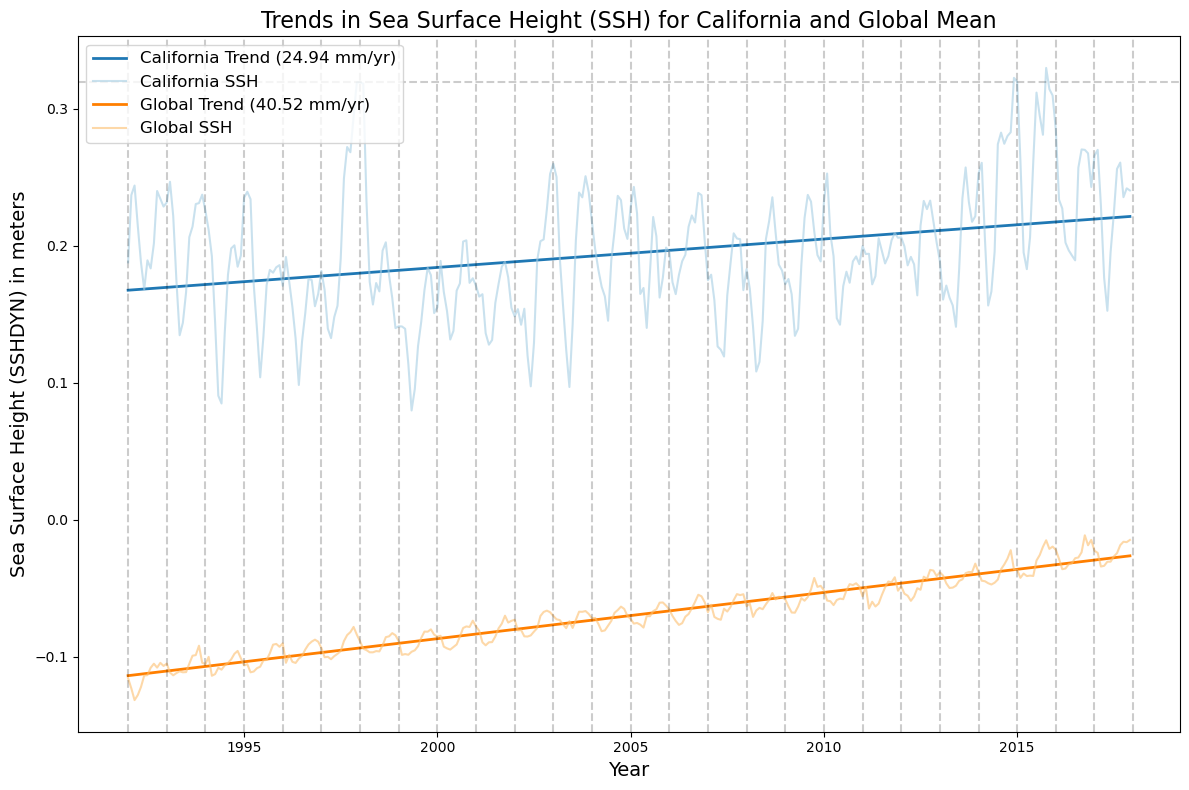

In [20]:
# create your plot here
fig = plt.figure(figsize=(12, 8))

plt.plot(decimal_years, california_slope * decimal_years + california_intercept, 
         label=f'California Trend ({california_slope * 1000 * 12:.2f} mm/yr)', color=plt.cm.Paired(1/12), linewidth=2)

plt.plot(decimal_years, cal_ssh_time_series[:, 1], color=plt.cm.Paired(0/12), alpha=0.6, label='California SSH')

plt.plot(decimal_years, global_slope * decimal_years + global_intercept, 
         label=f'Global Trend ({global_slope * 1000 * 12:.2f} mm/yr)', color=plt.cm.Paired(7/12), linewidth=2)

plt.plot(decimal_years, global_ssh_time_series[:, 1], color=plt.cm.Paired(6/12), alpha=0.6, label='Global SSH')

for year in range(1992, 2019):
    plt.axvline(year, color='black', linestyle='--', alpha=0.2)

plt.axhline(0.32, color='black', linestyle='--', alpha=0.2)

plt.title('Trends in Sea Surface Height (SSH) for California and Global Mean', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Sea Surface Height (SSHDYN) in meters', fontsize=14)

plt.legend(loc='upper left', fontsize=12)

plt.tight_layout()

plt.show()


### Questions:

How do the timeseries for Calfiornia and the global mean compare? Comment on their variability. What are the two highest years of sea level in California? What oceanographic phenomenon happened during this time?

Answer: California’s sea surface height (SSH) is higher than the global average but grows slower, at 25 mm/year compared to 40 mm/year globally. California shows more variability due to regional data. The highest SSH years are 2015-2016 and 1998, likely linked to the El Nino-Southern Oscillation (ENSO).